# Zbiór sp_retro - Adam Wiatrowski 148510

In [93]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import recall_score, roc_curve

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold

from imblearn.over_sampling import SMOTE

from imblearn.pipeline import Pipeline
from scipy.stats import loguniform, uniform

from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

#from catboost import CatBoostClassifier

import matplotlib.pyplot as plt

In [94]:
SEED = 42
ITERS = 3
CV = 5

## Wczytanie danych

Zgodnie z opisem zadania:
> Klasa decyzyjna jest binaryzowana: **klasa pozytywna** to `'CONSULT'`, czyli przypadki wymagające konsultacji, natomiast **klasa negatywna** to wszystkie inne przypadki.

In [95]:
def load_dataset(path='data/sp_retro_data.xls', sheet='Discretized Data (Final)', skiprows=2, na_values='?'):
    df = pd.read_excel(path, sheet_name=sheet, skiprows=skiprows, na_values=na_values)

    X = df.drop(columns=['TRIAGE'])
    X = X.drop(columns=['NUMBER'])

    y = df['TRIAGE'].apply(lambda x: x == 'CONSULT')

    return X, y

In [96]:
X, y = load_dataset()

## Wstępne przetwarzanie danych

Kolumny zawierające zbyt duży odsetek brakujących wartości są usuwane, aby poprawić jakość danych i uniknąć błędów podczas treningu.  
Następnie wszystkie zmienne kategoryczne są zamieniane na reprezentację binarną (`0/1`) przy użyciu kodowania one-hot (`pd.get_dummies`), co jest niezbędne dla modeli takich jak `BernoulliNB`, które wymagają danych binarnych.

In [104]:
def preprecess_data(data, delete_nans=False, threshold = 0.7):
    X, y = data
    
    if delete_nans:
        missing_fraction = X.isnull().mean()
        X = X.loc[:, missing_fraction <= threshold]

    X = pd.get_dummies(X)

    return X, y

## Funkcje pomocnicze

In [98]:
def calculate_metrics(
        y_true, y_pred_proba, medium_threshold, high_threshold
    ):
        """Calculate FNR, FPR and classification percentages."""
        # Apply thresholds to classify
        y_pred_medium = (y_pred_proba >= medium_threshold).astype(int)
        y_pred_high = (y_pred_proba >= high_threshold).astype(int)

        # For medium risk threshold (sensitivity >= 99%)
        tn_medium = np.sum((y_true == 0) & (y_pred_medium == 0))
        fp_medium = np.sum((y_true == 0) & (y_pred_medium == 1))
        fn_medium = np.sum((y_true == 1) & (y_pred_medium == 0))
        tp_medium = np.sum((y_true == 1) & (y_pred_medium == 1))

        # For high risk threshold (specificity >= 90%)
        tn_high = np.sum((y_true == 0) & (y_pred_high == 0))
        fp_high = np.sum((y_true == 0) & (y_pred_high == 1))
        fn_high = np.sum((y_true == 1) & (y_pred_high == 0))
        tp_high = np.sum((y_true == 1) & (y_pred_high == 1))

        # Calculate FNR and FPR
        fnr_medium = (
            fn_medium / (fn_medium + tp_medium) if (fn_medium + tp_medium) > 0 else 0
        )
        fpr_medium = (
            fp_medium / (fp_medium + tn_medium) if (fp_medium + tn_medium) > 0 else 0
        )
        fnr_high = fn_high / (fn_high + tp_high) if (fn_high + tp_high) > 0 else 0
        fpr_high = fp_high / (fp_high + tn_high) if (fp_high + tn_high) > 0 else 0

        # Calculate percentages of examples classified as negative and positive
        y_classified = np.zeros_like(y_true, dtype=int) - 1  # -1 for gray area
        y_classified[y_pred_proba < medium_threshold] = 0  # Negative
        y_classified[y_pred_proba >= high_threshold] = 1  # Positive

        neg_percent = np.mean(y_classified == 0)
        pos_percent = np.mean(y_classified == 1)

        return {
            "fnr_medium": fnr_medium,
            "fpr_medium": fpr_medium,
            "fnr_high": fnr_high,
            "fpr_high": fpr_high,
            "neg_percent": neg_percent,
            "pos_percent": pos_percent,
        }



def find_threshold(
        y_true, y_scores, criterion="sensitivity", target_value=0.99
    ):
        """Find threshold based on sensitivity or specificity target."""
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        if criterion == "sensitivity":
            # Find threshold where sensitivity (TPR) >= target_value
            valid_indices = np.where(tpr >= target_value)[0]
            if len(valid_indices) > 0:
                # Get the smallest threshold that meets the criterion
                idx = valid_indices[0]
                return thresholds[idx]
            else:
                # If no threshold meets the criterion, return minimum threshold
                return min(thresholds)
        elif criterion == "specificity":
            # Find threshold where specificity (1-FPR) >= target_value
            specificity = 1 - fpr
            valid_indices = np.where(specificity >= target_value)[0]
            if len(valid_indices) > 0:
                # Get the largest threshold that meets the criterion
                idx = valid_indices[-1]
                return thresholds[idx]
            else:
                # If no threshold meets the criterion, return maximum threshold
                return max(thresholds)

In [ ]:
def run_experiment(cls, dataset, iter=ITERS, cv=CV, seed=SEED, verbose=False, balance=False):

    X, y = dataset
    rskf = RepeatedStratifiedKFold(n_splits=cv, n_repeats=iter, random_state=seed)

    metrics_acc = {
        "auprc": [], "auroc": [],
        "fnr_medium": [], "fpr_medium": [],
        "fnr_high": [],   "fpr_high": [],
        "neg_percent": [], "pos_percent": []
    }

    for train_idx, test_idx in rskf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        if balance:
            X_int = X.astype(int)
            sm = SMOTE(random_state=seed)
            X_train_bal, y_train_bal = sm.fit_resample(X_int, y)

            cls.fit(X_train_bal, y_train_bal)
        else:
            cls.fit(X_train, y_train)

        y_train_proba = cls.predict_proba(X_train)[:, 1]
        y_test_proba = cls.predict_proba(X_test)[:, 1]

        metrics_acc["auprc"].append(average_precision_score(y_test, y_test_proba))
        metrics_acc["auroc"].append(roc_auc_score(y_test, y_test_proba))

        #medium_t, high_t = find_threshold(y_train, y_train_proba)
        medium_t = find_threshold(y_train, y_train_proba, "sensitivity", 0.99)
        high_t = find_threshold(y_train, y_train_proba, "specificity", 0.90)

        fold_metrics = calculate_metrics(y_test, y_test_proba, medium_t, high_t)

        for k, v in fold_metrics.items():
            metrics_acc[k].append(v)

        if verbose:
            print({k: f"{np.mean(metrics_acc[k][-1:]):.3f}" for k in metrics_acc})

    print({k: f"{np.mean(metrics_acc[k][-1:]):.3f}" for k in metrics_acc})
    return {k: np.mean(metrics_acc[k][-1:]) for k in metrics_acc}

In [100]:
pipe = Pipeline([
    ("smote", SMOTE(random_state=SEED)),
    ("clf", BernoulliNB())
])

param_dist = {
    "clf__alpha": loguniform(1e-4, 10),
    "clf__binarize": uniform(0, 1),
    "clf__fit_prior": [True, False]
}

rs = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=50,
    scoring="average_precision",
    cv=RepeatedStratifiedKFold(n_splits=CV, n_repeats=ITERS, random_state=SEED),
    n_jobs=-1,
    verbose=2,
    random_state=SEED
)

X_pre, y_pre = preprecess_data((X, y))
X_pre = X_pre.astype(int)

rs.fit(X_pre, y_pre)

print("Score:", rs.best_score_)
print("Params:", rs.best_params_)

best_nb = rs.best_estimator_

Fitting 15 folds for each of 50 candidates, totalling 750 fits
Score: 0.5542041166885154
Params: {'clf__alpha': 0.20540519425388448, 'clf__binarize': 0.31171107608941095, 'clf__fit_prior': False}


In [ ]:
res_baseline = run_experiment(LogisticRegression(), dataset=(X_pre, y_pre))
res_target = run_experiment(best_nb, dataset=(preprecess_data((X, y), delete_nans=True)), balance=True)

{'auprc': '0.724', 'auroc': '0.835', 'fnr_medium': '0.091', 'fpr_medium': '0.671', 'fnr_high': '0.364', 'fpr_high': '0.086', 'neg_percent': '0.296', 'pos_percent': '0.160'}
{'auprc': '0.793', 'auroc': '0.909', 'fnr_medium': '0.091', 'fpr_medium': '0.600', 'fnr_high': '0.273', 'fpr_high': '0.100', 'neg_percent': '0.358', 'pos_percent': '0.185'}


Zastosowano **BernoulliNB**, ponieważ dane wejściowe po zakodowaniu przy użyciu `get_dummies()` mają postać binarną (0/1). Model ten jest lekki, szybki i dobrze radzi sobie z dużą liczbą cech binarnych oraz dla niewielkich datasetów.

Ponieważ zbiór danych jest niezbalansowany, zastosowano **SMOTE** w celu zbalansowania rozkładu klas.

Dodatkowo, przeprowadzana jest optymalizacja hiperparametrów klasyfikatora BernoulliNB.

In [102]:
def show_result(res_baseline, res_target):
    labels = list(res_baseline.keys())

    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 12))
    axs = axs.flatten()

    for i, metric in enumerate(labels):
        ax = axs[i]
        # Rzutowanie na float dla bezpieczeństwa
        baseline_val = float(res_baseline[metric])
        target_val = float(res_target[metric])

        bars = ax.bar(['Baseline', 'Target'], [baseline_val, target_val],
                      color=['skyblue', 'lightgreen'])
        
        ax.set_ylim(0, min(1, 1.5 * max(baseline_val, target_val)))
        ax.set_title(metric)

        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}',
                    ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

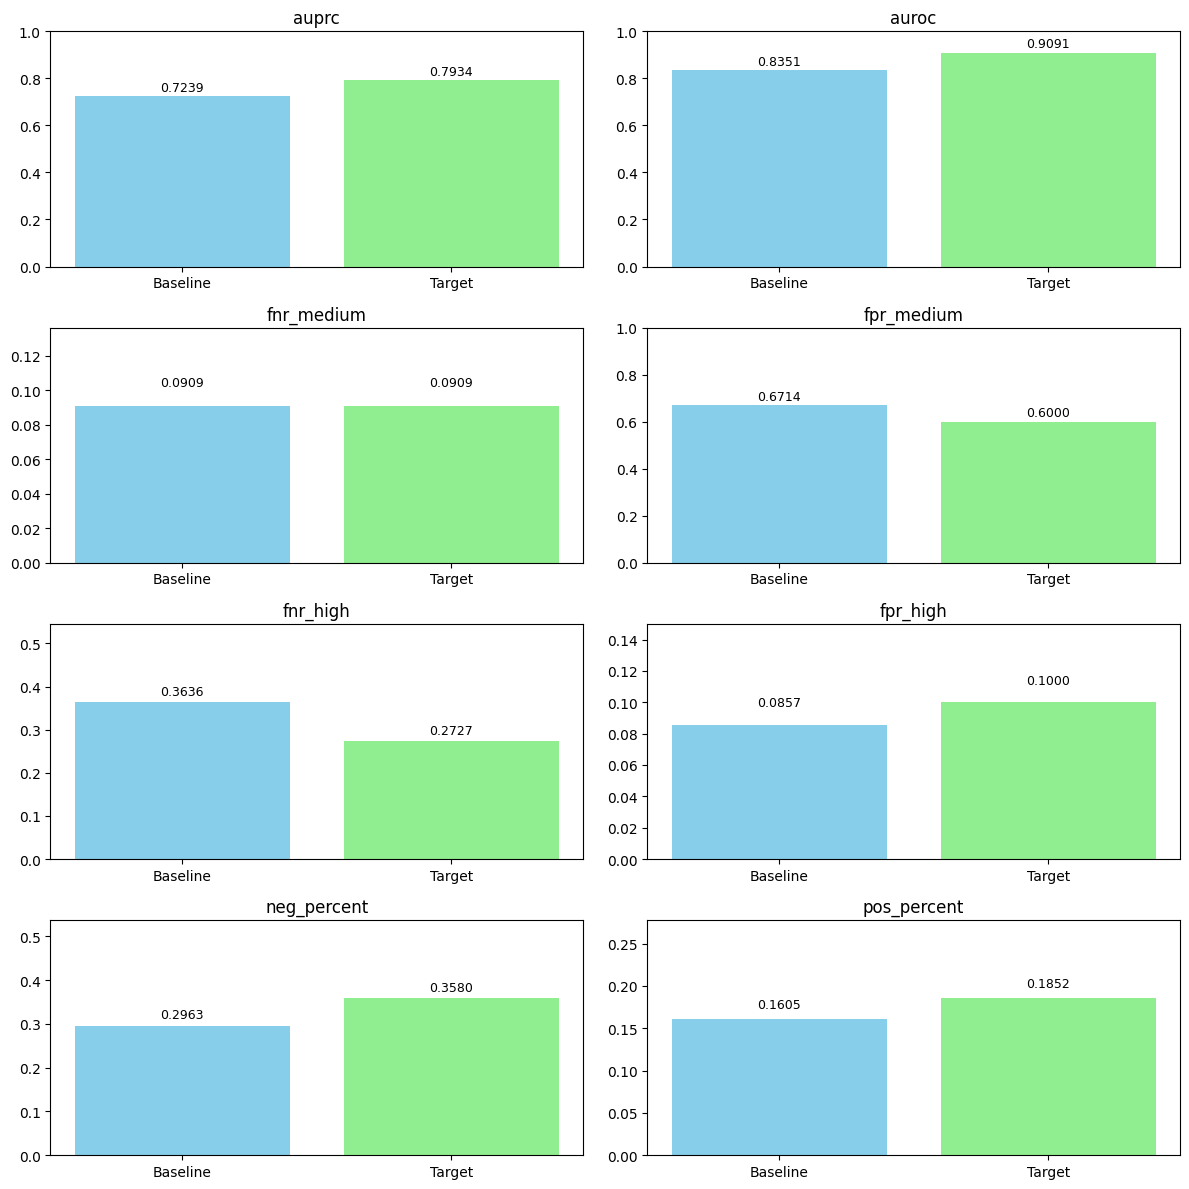

In [103]:
show_result(res_baseline, res_target)

## Interpretacja wyników:

1. AUPRC: 
> Proponowane roziwązanie osiąga lepsze wyniki na tej metryce, co wskazuje na lepszą jakość wykrywania klasy pozytywnej przy ograniczonej liczbie 'fałszywych alarmów', co jest szczególne istotne w przypadku danych niezbalansowanych.
2. AUROC: 
> Wyższy AUROC w modelu docelowym świadczy o lepszej zdolności rozróżniania między klasą pozytywną a negatywną.
3. FNR (MEDIUM): 
> FNR pozostał bez zmian, co oznacza, że oba modele mają podobną skuteczność w unikaniu pominięć przypadków średniego ryzyka.
4. FPR (MEDIUM): 
> Model docelowy popełnia mniej błędnych klasyfikacji pozytywnych wśród przypadków średniego ryzyka.
5. FNR (HIGH): 
> Znaczące obniżenie FNR wskazuje, że proponowany model lepiej wykrywa przypadki wysokiego ryzyka, zmniejszając ryzyko pomyłek typu false negative.
6. FPR (HIGH):
> Nieznaczny wzrost FPR oznacza więcej fałszywych alarmów w obszarze wysokiego ryzyka.